## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [57]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import re
import nltk
import string

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

# LDA 
from sklearn.decomposition import LatentDirichletAllocation

# for classification 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# to read dates to compute age 
import datetime
#set seed
import random
random.seed(10)


In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(10000).reset_index(drop = True) #I added ".reset_index to start everything at 0"
congress_tweets = congress_tweets.dropna(subset = ['text'])
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.245840e+18,RepCohen,2020-04-02T18:27:20-04:00,I want to commend @GovBillLee for his belated ...,Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,9,Democrat,"1,522,925","870,695","960,709","1,462,330"
1,1.268580e+18,RepRutherfordFL,2020-06-04T12:14:23-04:00,Excellent news! Thank you @realDonaldTrump and...,John Rutherford,Rep,3-Jan-17,9/2/1952,M,FL,4,Republican,"4,617,886","4,504,975","4,237,756","4,163,447"
2,1.124440e+18,SenWarren,2019-05-03T18:45:39-04:00,My plan to #EndCorruptionNow would stop senior...,Elizabeth Warren,Sen,3-Jan-13,6/22/1949,F,MA,Senate,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314"
3,1.169060e+18,RepDanCrenshaw,2019-09-03T21:41:55-04:00,Another ill conceived plan that priortizes han...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,2,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.189210e+18,RepFrenchHill,2019-10-29T11:44:53-04:00,Have you been watching season 4 of the hit @hu...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
#Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(remove_emoji)

In [4]:
#Remove urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(remove_urls)

In [5]:
#Remove line breaks
def remove_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(remove_lbreaks)

In [6]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("today")
    nlp.Defaults.stop_words.add("amp")
    nlp.Defaults.stop_words.add("rt")
    nlp.Defaults.stop_words.add("qt")
    nlp.Defaults.stop_words.add("need")
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
        
    spacy_words = [token.text.lower() for token in doc] #I added this to get everything in lowercase
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]

    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [7]:
#Making sure the text column doesn't have NAs
congress_tweets = congress_tweets.dropna(subset = ['text'])

#Using the function above to tokenize
congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

In [8]:
#Remove docs that have no words left in them
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)

In [9]:
#Remove quote around tokens
congress_tweets['tokens']=congress_tweets['tokens'].replace(r"'", "", regex=True)
congress_tweets['tokens'][0]

['want',
 'commend',
 'govbilllee',
 'belated',
 'decision',
 'shelterinplace',
 'recommendations',
 'mandatory',
 'practice',
 'proven',
 'effective',
 'flattening',
 'curve',
 'limiting',
 'exposure',
 'coronavirus',
 'save',
 'lives',
 'stayhomesavelives']

In [10]:
#Drop token that are just brackets
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
congress_tweets_notempty=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])

#Length of smallest tweet
congress_tweets_notempty['tokens'].str.len().min()

3

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 : Word Cloud

In [11]:
#Use word cloud to visualize most frequent words used dependeing on party affiliation or position
dem=congress_tweets[congress_tweets["party"]=="Democrat"]
rep=congress_tweets[congress_tweets["party"]=="Republican"]
congress=congress_tweets[congress_tweets["position"]=="Rep"]
senate=congress_tweets[congress_tweets["position"]=="Sen"]

In [12]:
def wordcloud(dat):
    
    text = dat["tokens"]
     #Convert the list of tokens into a string and put a space between tokens
    text = ' '.join(text.map(lambda text: ' '.join(text)))

    #Feed string to worldcloud: use the generate method to create a worldcloud object
    wordcloud = WordCloud().generate(text)

    #Plot
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()   

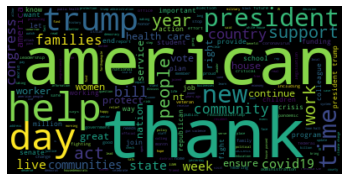

In [13]:
#Democratic reps
wordcloud(dem)

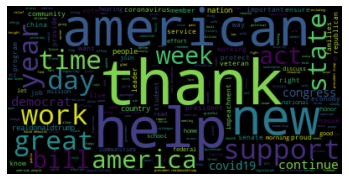

In [14]:
#Republican reps
wordcloud(rep)

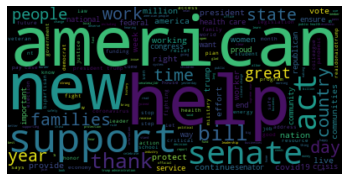

In [15]:
#Senators reps
wordcloud(senate)

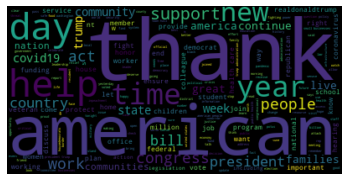

In [16]:
#Congresspeople reps
wordcloud(congress)

### EDA 2: Topic Modeling

In [17]:
#define function to print topics 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [18]:
# create 4 new variables that are blank space if n/a, rather than subset to avoid merging issues later 

congress_tweets['dem_tweets'] = ' ' # initialize as blank variable
congress_tweets.loc[congress_tweets['party']=='Democrat', 'dem_tweets'] = congress_tweets['text']

congress_tweets['rep_tweets'] = ' '
congress_tweets.loc[congress_tweets['party']=='Republican', 'rep_tweets'] = congress_tweets['text']

congress_tweets['house_tweets'] = ' '
congress_tweets.loc[congress_tweets['position']=='Rep', 'house_tweets'] = congress_tweets['text']

congress_tweets['sen_tweets'] = ' ' 
congress_tweets.loc[congress_tweets['position']=='Sen', 'sen_tweets'] = congress_tweets['text']

congress_tweets.head(10)  # seems okay... 

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,dem_tweets,rep_tweets,house_tweets,sen_tweets
0,1.245840e+18,RepCohen,2020-04-02T18:27:20-04:00,I want to commend @GovBillLee for his belated ...,Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,...,"1,522,925","870,695","960,709","1,462,330","[want, commend, govbilllee, belated, decision,...",19,I want to commend @GovBillLee for his belated ...,,I want to commend @GovBillLee for his belated ...,
1,1.268580e+18,RepRutherfordFL,2020-06-04T12:14:23-04:00,Excellent news! Thank you @realDonaldTrump and...,John Rutherford,Rep,3-Jan-17,9/2/1952,M,FL,...,"4,617,886","4,504,975","4,237,756","4,163,447","[excellent, news, thank, realdonaldtrump, stat...",32,,Excellent news! Thank you @realDonaldTrump and...,Excellent news! Thank you @realDonaldTrump and...,
2,1.124440e+18,SenWarren,2019-05-03T18:45:39-04:00,My plan to #EndCorruptionNow would stop senior...,Elizabeth Warren,Sen,3-Jan-13,6/22/1949,F,MA,...,"1,090,893","1,995,196","1,921,290","1,188,314","[plan, endcorruptionnow, stop, senior, govt, o...",25,My plan to #EndCorruptionNow would stop senior...,,,My plan to #EndCorruptionNow would stop senior...
3,1.169060e+18,RepDanCrenshaw,2019-09-03T21:41:55-04:00,Another ill conceived plan that priortizes han...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,...,"4,685,047","3,877,868","3,308,124","4,569,843","[ill, conceived, plan, priortizes, handicappin...",27,,Another ill conceived plan that priortizes han...,Another ill conceived plan that priortizes han...,
4,1.189210e+18,RepFrenchHill,2019-10-29T11:44:53-04:00,Have you been watching season 4 of the hit @hu...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,"684,872","380,494","394,409","647,744","[watching, season, 4, hit, hulu, television, s...",22,,Have you been watching season 4 of the hit @hu...,Have you been watching season 4 of the hit @hu...,
5,1.175060e+18,JimLangevin,2019-09-20T10:36:26-04:00,Nearly 1 in 10 students in #RI is an English l...,James Langevin,Rep,3-Jan-01,4/22/1964,M,RI,...,"180,543","252,525","279,677","157,204","[nearly, 1, 10, students, ri, english, learner...",17,Nearly 1 in 10 students in #RI is an English l...,,Nearly 1 in 10 students in #RI is an English l...,
6,1.176630e+18,MarshaBlackburn,2019-09-24T18:45:55-04:00,Partisan distractions aren’t going to distract...,Marsha Blackburn,Sen,3-Jan-19,6/6/1952,F,TN,...,"1,522,925","870,695","960,709","1,462,330","[partisan, distractions, going, distract, work...",17,,Partisan distractions aren’t going to distract...,,Partisan distractions aren’t going to distract...
7,1.235260e+18,DesJarlaisTN04,2020-03-04T12:29:22-05:00,RT @T_E_M_A TEMA has created a list of resourc...,Scott DesJarlais,Rep,3-Jan-11,2/21/1964,M,TN,...,"1,522,925","870,695","960,709","1,462,330","[tema, tema, created, list, resources, availab...",14,,RT @T_E_M_A TEMA has created a list of resourc...,RT @T_E_M_A TEMA has created a list of resourc...,
8,1.269310e+18,CongMikeSimpson,2020-06-06T12:50:58-04:00,Today is a sacred day for the free world. On J...,Mike Simpson,Rep,3-Jan-99,9/8/1950,M,ID,...,"409,055","189,765","212,787","420,911","[sacred, day, free, world, june, 6th, 1944, be...",19,,Today is a sacred day for the free world. On J...,Today is a sacred day for the free world. On J...,
9,1.172530e+18,RepMarthaRoby,2019-09-13T11:26:57-04:00,It was a productive week in D.C.! I had the pr...,Martha Roby,Rep,3-Jan-11,7/27/1976,F,AL,...,"1,318,255","729,547","795,696","1,255,925","[productive, week, dc, privilege, meeting, w, ...",28,,It was a productive week in D.C.! I had the pr...,It was a productive week in D.C.! I had the pr...,


In [19]:
# loop through each of the five variables containing tweets and create five topic models for each
var_list = ["text", "dem_tweets", "rep_tweets", "sen_tweets", "house_tweets"]
names = ["All tweets", "Democrats", "Republicans", "Senate", "House"]
all_topics_list = [] # initialize empty list to add topic dfs to 
for var,n in zip(var_list,names): 
    X = congress_tweets[var]
    tf = TfidfVectorizer(tokenizer = rem_punc_stop)
    tfidf_matrix =  tf.fit_transform(X)
    dense_matrix = tfidf_matrix.todense()
    lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
    lda = lda.fit(dense_matrix)
    tf_feature_names = tf.get_feature_names()
    print("The topics for " + n + " are: ")
    print_top_words(lda, tf_feature_names, 20)
    topic_dist = lda.transform(tfidf_matrix) 
    topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)
    all_topics_list.append(topic_dist_df) # not sure 

The topics for All tweets are: 

Topic #0:
  de small businesses students la program school loan covid19 cares apply en ppp    loans el y help student

Topic #1:
  trump president house people health act congress american americans bill work time support senate “ care — help new

Topic #2:
  covid19 thank day happy community join help women service mask    great food veterans coronavirus hall health men town

Topic #3:
hong kong discharge tune autonomy luck venezuela repbyrne petition infanticide interns celebrating westerncaucus yhn foxbusiness korean statue game   marines

Topic #4:
newsletter miners   weekly great blood guillen retired twitter thank family pensions patriotic 18th roberts christmas americanminersact warm fly ivankatrump

The topics for Democrats are: 

Topic #0:
trump   president covid19 help people federal new public house — time vote coronavirus census support    “ congress american

Topic #1:
  easter nunes baseball english blackgirlmagic m0nica10 dm weekvote duck

In [20]:
all_topics = pd.concat([all_topics_list[0],
                        all_topics_list[1],
                        all_topics_list[2], 
                        all_topics_list[3], 
                        all_topics_list[4]], axis=1)

all_topics.head() # scheisty list of 25 topics -- 5 for the whole set of tweets and 5 apiece for each of the four subgroups

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,0.274803,0.609473,0.039179,0.038336,0.038209,0.038895,0.037963,0.037992,0.847014,0.038135,...,0.600000,0.100000,0.100000,0.100000,0.100000,0.245191,0.039095,0.066286,0.038412,0.611016
1,0.031598,0.873370,0.031973,0.031498,0.031560,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.600000,0.100000,0.100000,0.100000,0.100000,0.037267,0.032557,0.032116,0.031961,0.866098
2,0.034831,0.500492,0.395950,0.034367,0.034360,0.618996,0.035888,0.272338,0.038462,0.034315,...,0.039171,0.854805,0.035226,0.036297,0.034501,0.599884,0.100031,0.100018,0.100023,0.100044
3,0.036806,0.518000,0.376927,0.034970,0.033297,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.600000,0.100000,0.100000,0.100000,0.100000,0.033289,0.527637,0.034678,0.033485,0.370911
4,0.039175,0.438965,0.443976,0.038942,0.038942,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.600000,0.100000,0.100000,0.100000,0.100000,0.345759,0.039858,0.040688,0.039958,0.533736


#### Examining the topics

*ALL TWEETS*: First, we created five topics based on the entire corpus of tweets to see if there are any apparent Democrat or Republican topics. Topic #1 seems to cover climate change and DACA, which are Democratic causes, but also contains less cut-and-dry terms about Venezuela PM Nicolas Maduro and Rudy Giuliani. Overall, there do not seem to be any useful topics based on the entire body of congressional tweets. 

*DEMOCRATS*: Among the topics created based on democrats' tweets, Topics #0 and #4 seem to be the most useful. Democrats may be more likely to tweet in Spanish as in #0, but the terms appear to be stopwords in Spanish. Topic #4 covers DACA and funding the post office. While together not necessarily a coherent topic, both have been major Democratic issues. 

*REPUBLICANS*: Unlike we might have expected, there do not appear to be any clear Make America Great Again topics. 

*SENATE*: The Senate terms seem to refer to the Senate itself, Amy Coney Barrett's confirmation process, veterans, and bills. The clusters of topics do not seem to be especially distinct from one another.  

*HOUSE*: As with the Senate, these topics do not seem to be especially coherent either. Gerrymandering comes up as a term which makes sense for the House, but the topic does not appear to be about gerrymandering.




***NOTE: even though we are using the same seed, the topics seem to change every so often despite us not changing any of the above code. The above text was relevant at least for the past few days...*** 


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 1. Compare 2 senators:

In [21]:
bernie_sanders = congress_tweets[congress_tweets["name_wikipedia"]=="Bernie Sanders"]
Nancy_Pelosi = congress_tweets[congress_tweets["name_wikipedia"]=="Nancy Pelosi"]
mitch_mcconnell = congress_tweets[congress_tweets["name_wikipedia"]=="Mitch McConnell"]

In [22]:
def sentiment(legislator):
    legislator.loc[:,'tokens']= legislator.loc[:,'tokens'].map(lambda text: ' '.join(text))
    legislator.loc[:,'polarity']= legislator.loc[:,'tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
    legislator.loc[:,'subjectivity']= legislator.loc[:,'tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
    return(legislator)

def threeplots(dat):
    fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.histplot(dat, x="polarity", ax=ax1)
    sns.histplot(dat, x="subjectivity", ax=ax2)
    sns.barplot(x=dat.subjectivity.round(2), y = 'polarity', data=dat, ax=ax3)
    return fig

In [23]:
bernie_sanders=sentiment(bernie_sanders)
Nancy_Pelosi=sentiment(Nancy_Pelosi)
mitch_mcconnell=sentiment(mitch_mcconnell)
dem_sentiment=sentiment(dem)
rep_sentiment=sentiment(rep)
senate_sentiment=sentiment(senate)
congress_sentiment=sentiment(congress)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


#### Bernie Sanders

<ipython-input-24-0ebfee07b780>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(bernie_sanders).show()


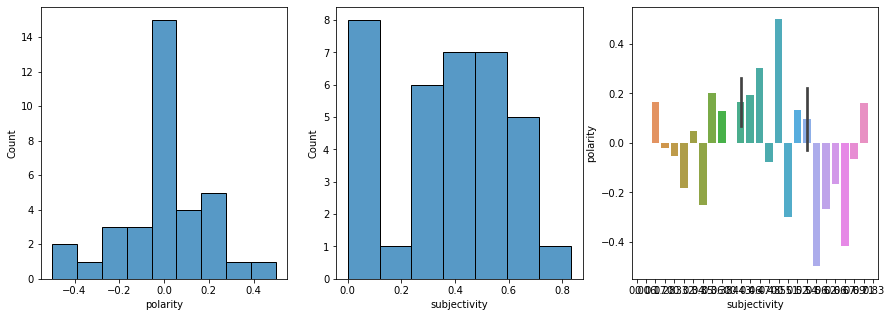

In [24]:
threeplots(bernie_sanders).show()

#### Mitch McConnell

<ipython-input-25-b68bcc6f07ff>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(mitch_mcconnell).show()


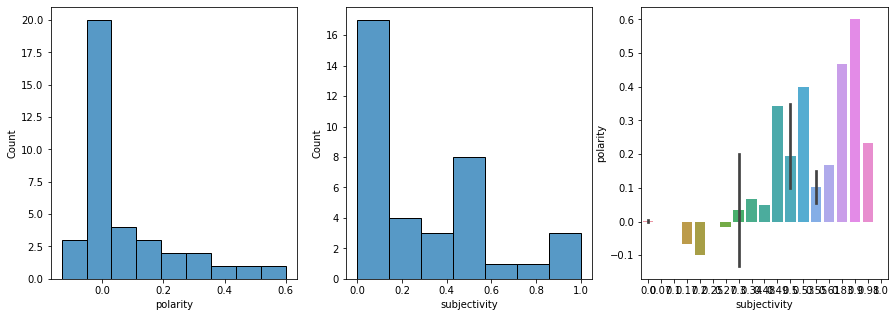

In [25]:
threeplots(mitch_mcconnell).show()

### 2. compare Democrats vs. Republicans 

#### Democrats

<ipython-input-26-1946d568614e>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(dem_sentiment).show()


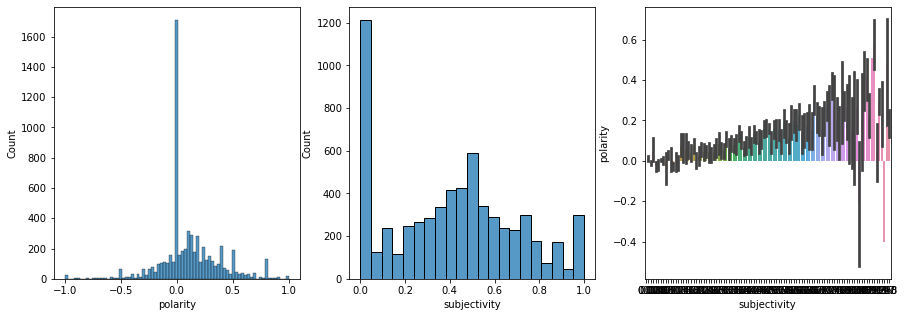

In [26]:
threeplots(dem_sentiment).show()

#### Republicans

<ipython-input-27-2b8d585f0767>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(rep_sentiment).show()


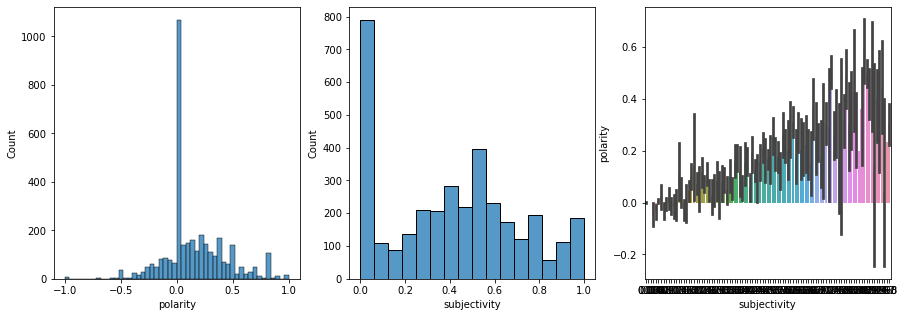

In [27]:
threeplots(rep_sentiment).show()

### 3. Compare Senators to Congresspeople

#### Senators

<ipython-input-28-91a0348dd227>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(senate_sentiment).show()


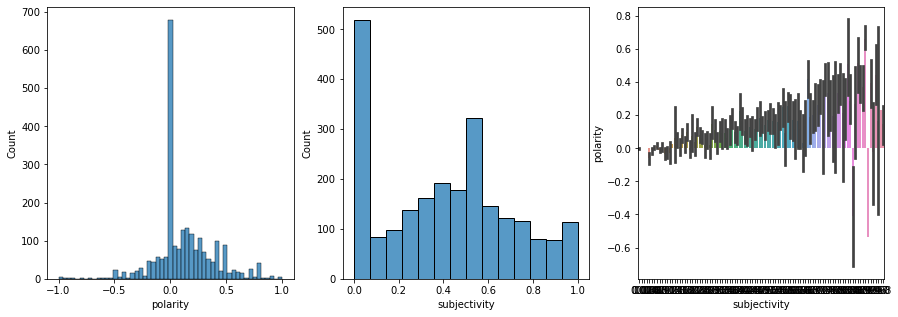

In [28]:
threeplots(senate_sentiment).show()

#### Congresspeople

<ipython-input-29-4eb25a0f8ba8>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(congress_sentiment).show()


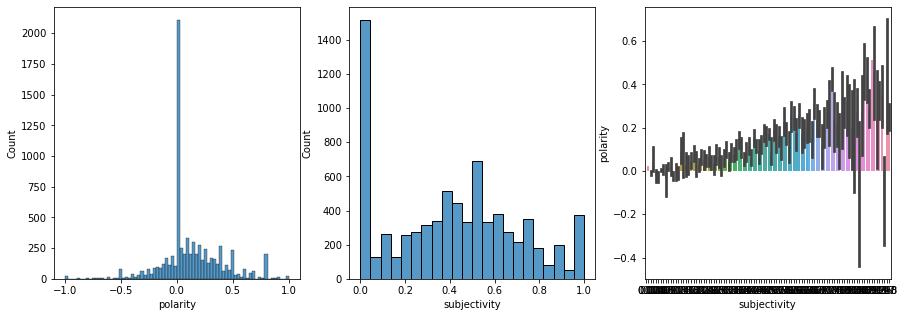

In [29]:
threeplots(congress_sentiment).show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [30]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text)) #made into string
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [31]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length_tokens', 'dem_tweets',
       'rep_tweets', 'house_tweets', 'sen_tweets', 'polarity', 'subjectivity'],
      dtype='object')

In [32]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,dem_tweets,rep_tweets,house_tweets,sen_tweets,polarity,subjectivity
0,1.245840e+18,RepCohen,2020-04-02T18:27:20-04:00,I want to commend @GovBillLee for his belated ...,Steve Cohen,Rep,3-Jan-07,5/24/1949,M,TN,...,"960,709","1,462,330",want commend govbilllee belated decision shelt...,19,I want to commend @GovBillLee for his belated ...,,I want to commend @GovBillLee for his belated ...,,0.600000,0.800000
1,1.268580e+18,RepRutherfordFL,2020-06-04T12:14:23-04:00,Excellent news! Thank you @realDonaldTrump and...,John Rutherford,Rep,3-Jan-17,9/2/1952,M,FL,...,"4,237,756","4,163,447",excellent news thank realdonaldtrump state dep...,32,,Excellent news! Thank you @realDonaldTrump and...,Excellent news! Thank you @realDonaldTrump and...,,0.366667,0.433333
2,1.124440e+18,SenWarren,2019-05-03T18:45:39-04:00,My plan to #EndCorruptionNow would stop senior...,Elizabeth Warren,Sen,3-Jan-13,6/22/1949,F,MA,...,"1,921,290","1,188,314",plan endcorruptionnow stop senior govt officia...,25,My plan to #EndCorruptionNow would stop senior...,,,My plan to #EndCorruptionNow would stop senior...,0.000000,0.000000
3,1.169060e+18,RepDanCrenshaw,2019-09-03T21:41:55-04:00,Another ill conceived plan that priortizes han...,Dan Crenshaw,Rep,3-Jan-19,3/14/1984,M,TX,...,"3,308,124","4,569,843",ill conceived plan priortizes handicapping eco...,27,,Another ill conceived plan that priortizes han...,Another ill conceived plan that priortizes han...,,0.175000,0.622222
4,1.189210e+18,RepFrenchHill,2019-10-29T11:44:53-04:00,Have you been watching season 4 of the hit @hu...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,"394,409","647,744",watching season 4 hit hulu television smbizrev...,22,,Have you been watching season 4 of the hit @hu...,Have you been watching season 4 of the hit @hu...,,0.700000,0.900000


### Engineered Text Features

In [33]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = all_topics.join(engineered_features.reset_index(drop = True))

In [34]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,0,1,2,3,4,...,2,3,4,0,1,2,3,4,polarity,subjectivity
0,0.274803,0.609473,0.039179,0.038336,0.038209,0.038895,0.037963,0.037992,0.847014,0.038135,...,0.100000,0.100000,0.100000,0.245191,0.039095,0.066286,0.038412,0.611016,0.600000,0.800000
1,0.031598,0.873370,0.031973,0.031498,0.031560,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.100000,0.100000,0.100000,0.037267,0.032557,0.032116,0.031961,0.866098,0.366667,0.433333
2,0.034831,0.500492,0.395950,0.034367,0.034360,0.618996,0.035888,0.272338,0.038462,0.034315,...,0.035226,0.036297,0.034501,0.599884,0.100031,0.100018,0.100023,0.100044,0.000000,0.000000
3,0.036806,0.518000,0.376927,0.034970,0.033297,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.100000,0.100000,0.100000,0.033289,0.527637,0.034678,0.033485,0.370911,0.175000,0.622222
4,0.039175,0.438965,0.443976,0.038942,0.038942,0.100024,0.599954,0.100001,0.100021,0.100000,...,0.100000,0.100000,0.100000,0.345759,0.039858,0.040688,0.039958,0.533736,0.700000,0.900000


### Bag-of-words or Tf-idf

In [35]:
# Frequency Based featurization (TF-idf)
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

In [36]:
tfidf_df.head()

,,,,,,,,,,,...,🦹,🧀,🧐,🧘,🧡,🧪,🧸,🧹,🧼,🩺
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.063735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.076823,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [37]:
#Using the function to re-tokenize
congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

In [38]:
# Drop the tokens that aren't words in the model
model_words = []
i=0
for tweet in congress_tweets_notempty['tokens']:
    doc = [word for word in tweet if word in model.wv.vocab]
    if len(doc) < 1:
        model_words.append(i)
    i =i+1

print(model_words)

#Shape of congress_tweets_notempty
congress_tweets_notempty.shape


#Drop if the index is the same
congress_tweets_CLEAN=congress_tweets_notempty.drop(congress_tweets_notempty.index[[model_words]])

congress_tweets_CLEAN.shape

[769, 2022, 7247]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:3941: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


(9897, 18)

In [39]:
#just wanted to test out what the output from the model looks like
model['american']

<ipython-input-39-be15e3d15016>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model['american']


array([-2.47547060e-01,  3.58878553e-01, -3.99639428e-01, -3.40873480e-01,
       -3.75525028e-01, -7.82409787e-01,  4.87717777e-01, -2.12000862e-01,
       -4.37680492e-03, -6.10932633e-02,  7.73265660e-02,  1.45074829e-01,
        2.80122876e-01, -9.40031633e-02,  6.17983714e-02,  2.29642287e-01,
       -1.79499194e-01, -6.79315999e-03, -3.87485266e-01,  2.29640543e-01,
        8.87205452e-02,  1.51184916e-01, -4.69874591e-01,  1.13716081e-01,
       -2.00985432e-01, -6.31191671e-01, -3.96730483e-01, -1.97837874e-01,
        3.85506958e-01, -4.65954989e-01,  2.43491292e-01, -1.08380064e-01,
       -3.02810252e-01, -1.98268075e-03,  1.25145599e-01, -1.09433877e+00,
       -2.64865547e-01,  3.01011384e-01,  9.54952985e-02, -4.27254289e-01,
       -9.86999348e-02, -5.99774778e-01, -4.67869937e-01,  1.28446683e-01,
        7.76598871e-01, -2.18202263e-01, -1.53198928e-01, -5.18981018e-04,
       -1.60090446e-01, -1.96347281e-01,  7.56200077e-03, -9.56370950e-01,
        6.05184615e-01, -

In [40]:
#also just wanted to see what the first 100 words are in our vocabulary
words = list(model.wv.vocab)
print(words[0:100])

['want', 'commend', 'decision', 'recommendations', 'mandatory', 'practice', 'proven', 'effective', 'curve', 'limiting', 'exposure', 'coronavirus', 'save', 'lives', 'excellent', 'news', 'thank', 'realdonaldtrump', 'state', 'department', 'officials', 'working', 'secure', 'release', ' ', 'happy', 'announce', 'navy', 'veteran', 'michael', 'white', 'detained', 'iran', 'days', 'left', 'iranian', 'expect', 'home', 'family', 'america', 'soon', 'plan', 'stop', 'senior', 'govt', 'leaving', 'immediately', 'getting', 'paid', 'gave', 'contracts', 'fighting', 'law', 'kelly', 'try', 'board', 'ill', 'economy', 'reducing', 'global', 'sure', 'cnn', 'climate', 'town', 'hall', 'tomorrow', 'based', 'facts', 'good', 'ideas', 'fear', 'socialism', 'form', '“', 'environmental', 'policy', '”', 'watching', 'season', '4', 'hit', 'features', 'arkansas', 'highlights', 'stories', '6', 'incredible', 'entrepreneurs', 'click', 'read', 'latest', 'district', 'update', 'nearly', '1', '10', 'students', 'ri', 'english', 'el

In [41]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [42]:
# embedding based featurization
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in congress_tweets_CLEAN['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [43]:
doc_average_embeddings

array([[-0.16524617,  0.16999073, -0.1933341 , ...,  0.31300357,
         0.25827065, -0.23018704],
       [-0.2337828 ,  0.2629288 , -0.26161557, ...,  0.4866629 ,
         0.3504404 , -0.35544536],
       [-0.21526663,  0.23009406, -0.25220293, ...,  0.43016186,
         0.3279967 , -0.3214247 ],
       ...,
       [-0.23014864,  0.24200012, -0.26452625, ...,  0.4446551 ,
         0.36222717, -0.3260548 ],
       [-0.24128927,  0.26583606, -0.2739284 , ...,  0.49293393,
         0.3662342 , -0.36084378],
       [-0.2386529 ,  0.26568168, -0.27042666, ...,  0.47421625,
         0.35976565, -0.3610325 ]], dtype=float32)

In [44]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [45]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

# create relevant objects to loop through DFs 
dataframes = [engineered_features_with_topics, tfidf_df] #, word2vec_features_df] # list of dfs to train models on
featurization_technique = ['Engineered Features (polarity, subjectivity, topics)', 'Tf-idf Features'] #, 'Word2Vec Features'] # list of ft techniques for labeling 

In [46]:
# create relevant objects to loop through targets
lb_style = LabelBinarizer()
congress_tweets['party'].value_counts() # bernie stirring up trouble  
congress_tweets[congress_tweets.party.eq('Independent')] # bernie and angus king caucus with dems, will rc them as such
congress_tweets.loc[congress_tweets['party'] == 'Independent', 'party'] = 'Democrat' # rc independents to dems

# binarize two clean target variables
congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets['party'])
congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets['position'])

In [47]:
print(congress_tweets[['party','party_binary','position','position_binary']]) # check how labels came out to make sure 0/1s match
binarized_targets = ['party_binary', 'position_binary']
loop_labels = [["Democrat", "Republican"],["House", "Senate"]]

           party  party_binary position  position_binary
0       Democrat             0      Rep                0
1     Republican             1      Rep                0
2       Democrat             0      Sen                1
3     Republican             1      Rep                0
4     Republican             1      Rep                0
...          ...           ...      ...              ...
9969    Democrat             0      Sen                1
9970    Democrat             0      Rep                0
9971    Democrat             0      Rep                0
9972  Republican             1      Rep                0
9973    Democrat             0      Rep                0

[9974 rows x 4 columns]


#### Now, we loop through three dfs and two targets: 

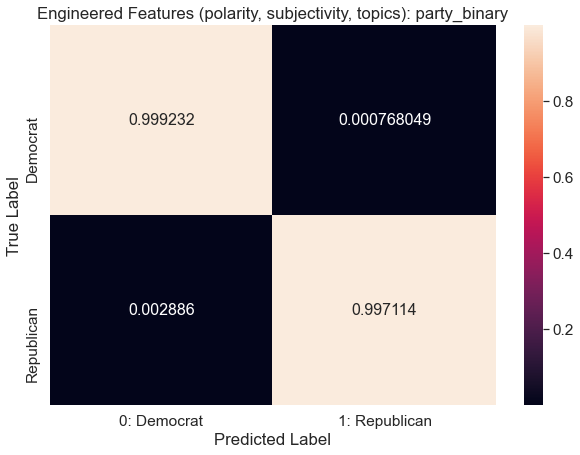

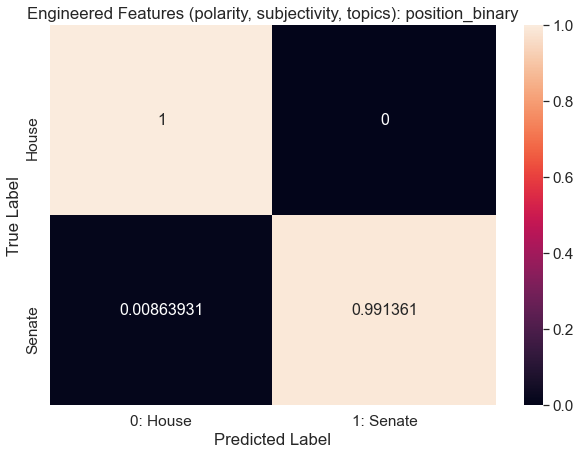

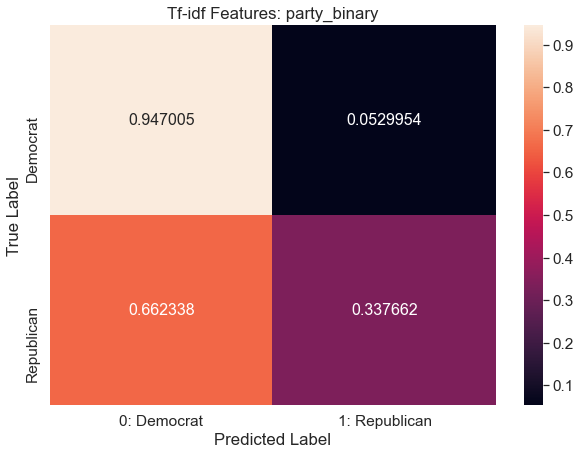

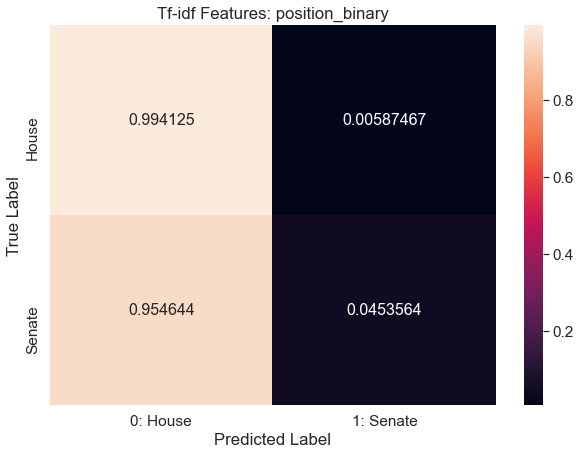

In [48]:
for df, ft in zip(dataframes,featurization_technique):      
    for t,lab in zip(binarized_targets, loop_labels):
        y = congress_tweets[t]
        X_train, X_test, y_train, y_test = train_test_split(df, 
                                                            y, 
                                                            train_size = .80, 
                                                            test_size=0.20, 
                                                            random_state = 10)

        # create a model
        logit_reg = LogisticRegression()

        # fit the model
        logit_model = logit_reg.fit(X_train, y_train.ravel())

        y_pred = logit_model.predict(X_test)
    
        cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

        df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

        df_cm = df_cm.rename(index=str, columns={0: ("0: " + lab[0]), 1: ("1: " + lab[1])})
        df_cm.index = lab
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, 
                   annot=True,
                   annot_kws={"size": 16},
                   fmt='g')
        plt.title(ft + ": " + t)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

The engineered features—polarity, subjectivity, and the 25 topics—do extremely well at predicting both party and position. They are predicting each category upwards of 99 percent of the time. 

### Two Combined Models

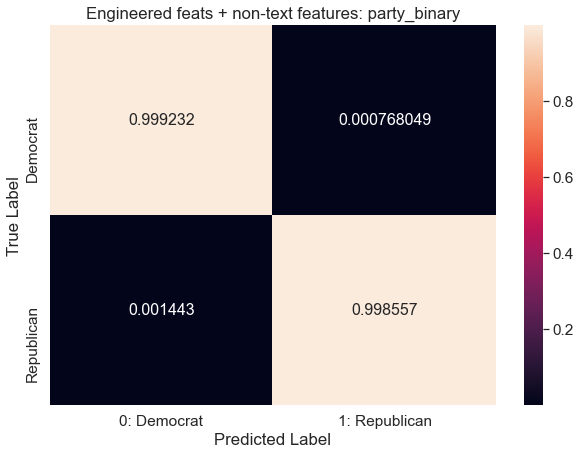

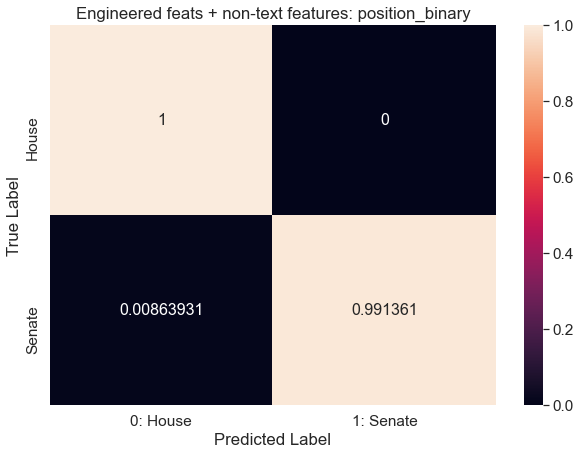

In [77]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# Non-text features
to_dummies = congress_tweets[['joined_congress_date', 
                              'gender']] 
#non_text_features['age'] = date(congress_tweets['datetime']) - date(congress_tweets['birthday'])

non_text_features_dummies = pd.get_dummies(to_dummies).reset_index(drop = True)

X = pd.concat([non_text_features_dummies, engineered_features_with_topics], axis=1)

# Non-text features + engineered features
#non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

for t,lab in zip(binarized_targets, loop_labels):
    y = congress_tweets[t]
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)

    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                   range(2))

    df_cm = df_cm.rename(index=str, columns={0: ("0: " + lab[0]), 1: ("1: " + lab[1])})
    df_cm.index = lab
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, 
                annot=True,
                annot_kws={"size": 16},
                fmt='g')
    plt.title("Engineered feats + non-text features" + ": " + t)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [66]:
non_text_features_dummies.head(20)

,joined_congress_date_10-Apr-18,joined_congress_date_10-Jul-18,joined_congress_date_10-Mar-05,joined_congress_date_10-May-94,joined_congress_date_10-Sep-15,joined_congress_date_11-Apr-13,joined_congress_date_11-Dec-07,joined_congress_date_11-Jul-17,joined_congress_date_11-Mar-08,joined_congress_date_12-Apr-18,...,"romney_2012_state_share_634,892","romney_2012_state_share_647,744","romney_2012_state_share_692,634","romney_2012_state_share_710,746","romney_2012_state_share_730,617","romney_2012_state_share_740,600","romney_2012_state_share_754,175","romney_2012_state_share_891,325","romney_2012_state_share_92,698","romney_2012_state_share_971,869"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Discussion Questions

*1. Why do standard preprocessing techniques need to be further customized to a particular corpus?*

Standard preprocessing techniques need to be further customized to a particular corpus because each corpora has nuances that standard preprocessing techniques (removing stop words and punctuation) don’t capture. For example, in our tweet dataset we needed to remove the twitter handles which are not part of normal speech but are unique to this corpus. We also chose to remove the words “today” and “need” which are the most frequently used words by all users in our dataset and are non-discriminatory for our analysis.

*2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?*

The sentiment analysis didn’t reveal any visible differences between Democrats and Republicans, congresspeople and senators. We assume that this type of analysis isn’t best suited for the political context, where there is much more nuance and cultural context to what might be considered polarizing or subjective. For example, in 2018 after the polarizing fight over the confirmation of Brett Kavanaugh to the Supreme Court, Senate Majority Leader Mitch McConnell tweeted "the country will be just fine". Our sentiment analysis will consider this statement to be positive and not polarizing, but that assessment doesn’t reflect the public response to this tweet.

*3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?*

At first glance, our unsupervised learning approaches (most notably topic modeling) did not appear to yield useful information. As we discussed above, the topics for all groups and each subgroup seemed incoherent. However, it is evident that they were picking up meaningful patterns in the tweets that were not immediately visible to us based on the performance of the engineered text features. 

*4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?*

The non-text